# Guide to using .group()

In this example, we're going to go over how to use tbl.group() on a specific data set.

In [59]:
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Fix for datascience plots
import collections as collections
import collections.abc as abc
collections.Iterable = abc.Iterable
import numpy as np

Below is a table that displays data about the sales (in millions) of each video game genre. The genres are separated by both year and region.

In [113]:
game_sales = Table.read_table('year_genre_region.csv').relabeled("sales", "sales (in millions)").where("region", are.not_equal_to("Worldwide"))
game_sales

release_year,genre,region,sales (in millions)
1980,Action,North America,0.32
1980,Fighting,North America,0.72
1980,Misc,North America,2.53
1980,Shooter,North America,6.56
1980,Sports,North America,0.46
1981,Action,North America,13.86
1981,Platform,North America,6.47
1981,Puzzle,North America,2.09
1981,Racing,North America,0.45
1981,Shooter,North America,9.37


Let's say that we wanted to use this dataset to find the **total sales of each genre.** Which genre sold the most? To do this, we can use tbl.group()

tbl.group() is used like this...

- tbl.group(column_or_columns, func)

...where column_or_columns is a string (or a list of strings), and func is the name of the function. func is also an optional argument. Let's just see what happens when we only provide one column as our argument

In [97]:
game_sales.group("genre")

genre,count
Action,152
Adventure,112
Fighting,116
Misc,124
Platform,144
Puzzle,136
Racing,128
Role-Playing,128
Shooter,144
Simulation,124


As you can see, each genre becomes grouped into one row. Every unique genre that was in the column is listed only once. 

But what is the "count" column? That's where the "func" argument comes in. Because we didn't put in a second argument, func defaults to "count". That is to say, if we don't give a second argument, then the computer will use the function named "count" to count each instance of how many times each genre appears. This isn't very useful for what we want to do right now, so let's provide a more useful argument for func.

In [98]:
game_sales.group("genre", sum)

genre,release_year sum,region sum,sales (in millions) sum
Action,303772,,1716.53
Adventure,224244,,233.33
Fighting,232172,,442.66
Misc,248036,,790.29
Platform,287784,,825.55
Puzzle,271892,,239.89
Racing,256008,,723.49
Role-Playing,256192,,931.13
Shooter,287744,,1041.36
Simulation,248220,,388.25


This time, we made our second argument "sum", so for each genre, the computer used the sum function on every column that *isn't* the one we want to group. As you can see, several things happened here. 
- We used sum on every release year. That means that for each year an action game released, we did "1980 + 1981 + 1982..." and so on to get our final result of 379715. Then we did the same for each year an adventure game released, then the same for fighting games, and so on.
- We used sum on every region. Because each region is represented by a string, and sum only takes an array of integers as its argument, it detects that the data types are incompatible and leaves the entire column empty.
- We used sum on every sales figure. This ends up giving us the total number of copies each genre sold, which is actually exactly what we want in this case!

We're very close to getting the table we want. We just want to avoid using sum on the release_year and region column. The easiest way to do this is to just drop those 2 columns before using .group(). We can do this by using .drop(), which just gets rid of all of the columns we list, like so:

In [99]:
game_sales.drop("release_year", "region")

genre,sales (in millions)
Action,0.32
Fighting,0.72
Misc,2.53
Shooter,6.56
Sports,0.46
Action,13.86
Platform,6.47
Puzzle,2.09
Racing,0.45
Shooter,9.37


If we combine .drop() and .group(), we can get our desired output like so:

In [100]:
correct_output = game_sales.drop("release_year", "region").group("genre", sum)
#ignore the use of .show() here, that's only done to get every row listed.
correct_output.show(12)

genre,sales (in millions) sum
Action,1716.53
Adventure,233.33
Fighting,442.66
Misc,790.29
Platform,825.55
Puzzle,239.89
Racing,723.49
Role-Playing,931.13
Shooter,1041.36
Simulation,388.25


We got the output that we want! If we just sort this table, we can see that action games have sold the most overall, with 1716.53 million copies across all regions in the dataset. Meanwhile, strategy games have sold the least,with 172.57 million copies across all regions in the dataset.

In [101]:
correct_output.sort(1, descending=True).show(12)

genre,sales (in millions) sum
Action,1716.53
Sports,1309.67
Shooter,1041.36
Role-Playing,931.13
Platform,825.55
Misc,790.29
Racing,723.49
Fighting,442.66
Simulation,388.25
Puzzle,239.89


What if we wanted to find the average number of copies each game sold instead of the total number? We just change the second argument that goes into .group()! If we use np.average instead of sum, this is the result we get:

In [102]:
average_sales = game_sales.drop("release_year", "region").group("genre", np.average).sort(1, descending = True)
average_sales.show(12)

genre,sales (in millions) average
Action,11.293
Sports,8.84912
Role-Playing,7.27445
Shooter,7.23167
Misc,6.37331
Platform,5.73299
Racing,5.65227
Fighting,3.81603
Simulation,3.13105
Adventure,2.0833


What if we wanted to see the **total sales of each genre for each year?** In this case, we want to use group both the release_year and the genre. You might think we have to do:
- game_sales.group("release_year", "genre", sum)

But if we do that, we actually get an error!

In [114]:
#this cell gives an error
game_sales.drop("region").group("release_year", "genre", sum)

TypeError: Table.group() takes from 2 to 3 positional arguments but 4 were given

This is because .group only takes 2 arguments. So if we want to group multiple columns, we must make either a list of every column we want to group **OR** an array of every column we want to group. For example:

In [115]:
array_of_columns = make_array("release_year", "genre") #an array containing the names of all columns we want to group
sales_per_year = game_sales.drop("region").group(array_of_columns, sum)
sales_per_year

release_year,genre,sales (in millions) sum
1980,Action,0.34
1980,Fighting,0.77
1980,Misc,2.7
1980,Shooter,7.07
1980,Sports,0.5
1981,Action,14.79
1981,Platform,6.92
1981,Puzzle,2.25
1981,Racing,0.48
1981,Shooter,10.02


This gives us the output that we want! We have correctly grouped both the release years and the genres in the dataset.

But what if we want to plot this data as a line graph, with different lines for each genre? To do this, we'll use tbl.pivot()

pivot() takes a table and converts it into a pivot table. It's used like this:
- tbl.pivot(col1, col2, values, collect)
 
Here's each argument explained:
- "col1" is the name of the column where **every unique value will get its own column in the pivot table**. So if "col1" is set to "genre", then each individual genre will get its own column.
- "col2" is the name of the column where **every unique value will get its own row**. So if "col2" is set to "release_year", then every year listed in the data set will be listed in each row.
- "values" is an optional argument. It's the name of the column where **each value will be a cell in the pivot table.** 
- "collect" is an optional argument. It describes **how the values will be collected.**

Using all of this, we can make a pivot table like so:

In [105]:
pivot_table = sales_per_year.pivot("genre", "release_year", values = "sales (in millions) sum", collect=sum)
pivot_table.show(40) #again, ignore the use of .show() here. It's only used to show the entire pivot table.

release_year,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
1980,0.34,0,0.77,2.7,0,0,0,0,7.07,0,0.5,0
1981,14.79,0,0,0,6.92,2.25,0.48,0,10.02,0.44,0.78,0
1982,6.5,0,0,0.87,5.03,10.04,1.57,0,3.81,0,1.06,0
1983,2.86,0.4,0,2.14,6.93,0.78,0,0,0.49,0,3.2,0
1984,1.85,0,0,1.45,0.69,3.14,5.95,0,31.1,0,6.17,0
1985,3.52,0,1.05,0,43.17,3.21,0,0,1,0.04,1.96,0
1986,13.74,0,0,0,9.39,0,1.96,2.52,3.89,0,5.58,0
1987,1.11,4.38,5.42,0,1.74,0,0,4.65,0.69,0,3.71,0
1988,1.74,0,0,0,27.73,5.58,2.14,5.88,0.51,0.03,3.6,0
1989,4.65,0,0,1.28,20.66,37.75,0,2.2,1.19,0,5.72,0


As you can see, each genre is listed on the top. Each year is listed on the left. Each sales figure is listed in the middle.
Now we can plot the total number of sales for each genre. To plot multiple lines on one graph, use the optional argument "overlay=True"

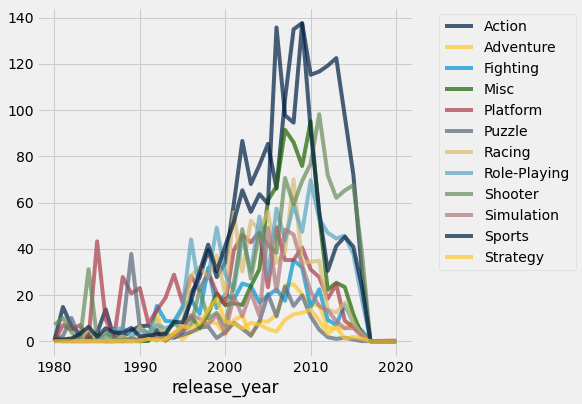

In [106]:
pivot_table.plot("release_year", overlay=True)

Let's do one last exercise. **Let's plot the sales of only action games for each year in each region.**

To start, we'll use .where() to filter out all other genres of games.

In [107]:
action_games = game_sales.where("genre", "Action")
action_games

release_year,genre,region,sales (in millions)
1980,Action,North America,0.32
1981,Action,North America,13.86
1982,Action,North America,6.07
1983,Action,North America,2.67
1984,Action,North America,0.8
1985,Action,North America,1.64
1986,Action,North America,6.52
1987,Action,North America,1.04
1988,Action,North America,1.15
1989,Action,North America,3.83


Next, let's use .drop() and .group() to group only the columns we're interested in.

In [109]:
column_choices = make_array("release_year", "region")
grouped_action = action_games.drop("genre").group(column_choices, sum)
grouped_action

release_year,region,sales (in millions) sum
1980,European Union,0.02
1980,Japan,0
1980,North America,0.32
1980,Other,0
1981,European Union,0.81
1981,Japan,0
1981,North America,13.86
1981,Other,0.12
1982,European Union,0.38
1982,Japan,0


Finally, let's use .pivot() to convert this table into a pivot table

In [111]:
action_pivot = grouped_action.pivot("region", "release_year", values = "sales (in millions) sum", collect=sum)
action_pivot

release_year,European Union,Japan,North America,Other
1980,0.02,0,0.32,0
1981,0.81,0,13.86,0.12
1982,0.38,0,6.07,0.05
1983,0.17,0,2.67,0.02
1984,0.19,0.83,0.8,0.03
1985,0.38,1.44,1.64,0.06
1986,1.66,5.31,6.52,0.25
1987,0.06,0,1.04,0.01
1988,0.16,0.42,1.15,0.01
1989,0.46,0.31,3.83,0.05


Finally, let's plot our table!

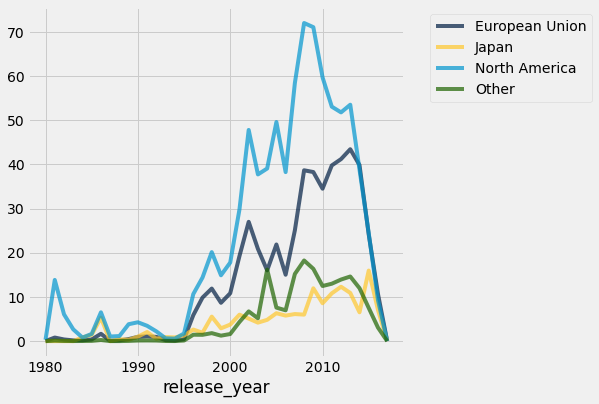

In [112]:
action_pivot.plot("release_year", overlay=True)

We have successfully managed to plot different genres of video game sales using .group() and .pivot()! Hopefully, this example shows you how to correctly use these 2 table functions in future labs and mini-projects.